# Multilabel classification with DistilBERT 

Welcome to this notebook! In this exercise we will fine-tune a BERT model that's capable of classifying complaints from customers of a bank. The complaints can belong to different categories such as 'Debt collection', 'Mortgage', etc.

In [1]:
import pandas as pd 
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn 
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW,  get_linear_schedule_with_warmup, pipeline 
from sklearn.metrics import f1_score, precision_score, multilabel_confusion_matrix, matthews_corrcoef
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import transformers
import evaluate 
import missingno as ms


# Check torch and CUDA versions
print(torch.__version__)  # Should display the version of PyTorch with CUDA support
print(torch.version.cuda)  # Should display the CUDA version
print(torch.backends.cudnn.version())  # Should display the cuDNN version
print(torch.cuda.is_available())  # Should return True if CUDA is available

d:\llm-solutions\sequence_classification\customer-complaint-classification_DistilBERT\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.3.1+cu118
11.8
8700
True


First, let's set some environment variables:
1. Subsample: this is an optional feature to work on a portion of the dataset so we can speed up the computation time. 
2. Seed: to make the results replicable
3. LR (Learning Rate): the higher, the faster the model converges to an optimal solution, but there's a risk of getting stuck in a local minima and not finding the global minimum.
4. Batch size: 

Loading raw data...


C:\Users\hp\AppData\Local\Temp\ipykernel_20928\4074938379.py:20: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('consumer_complaints.csv')


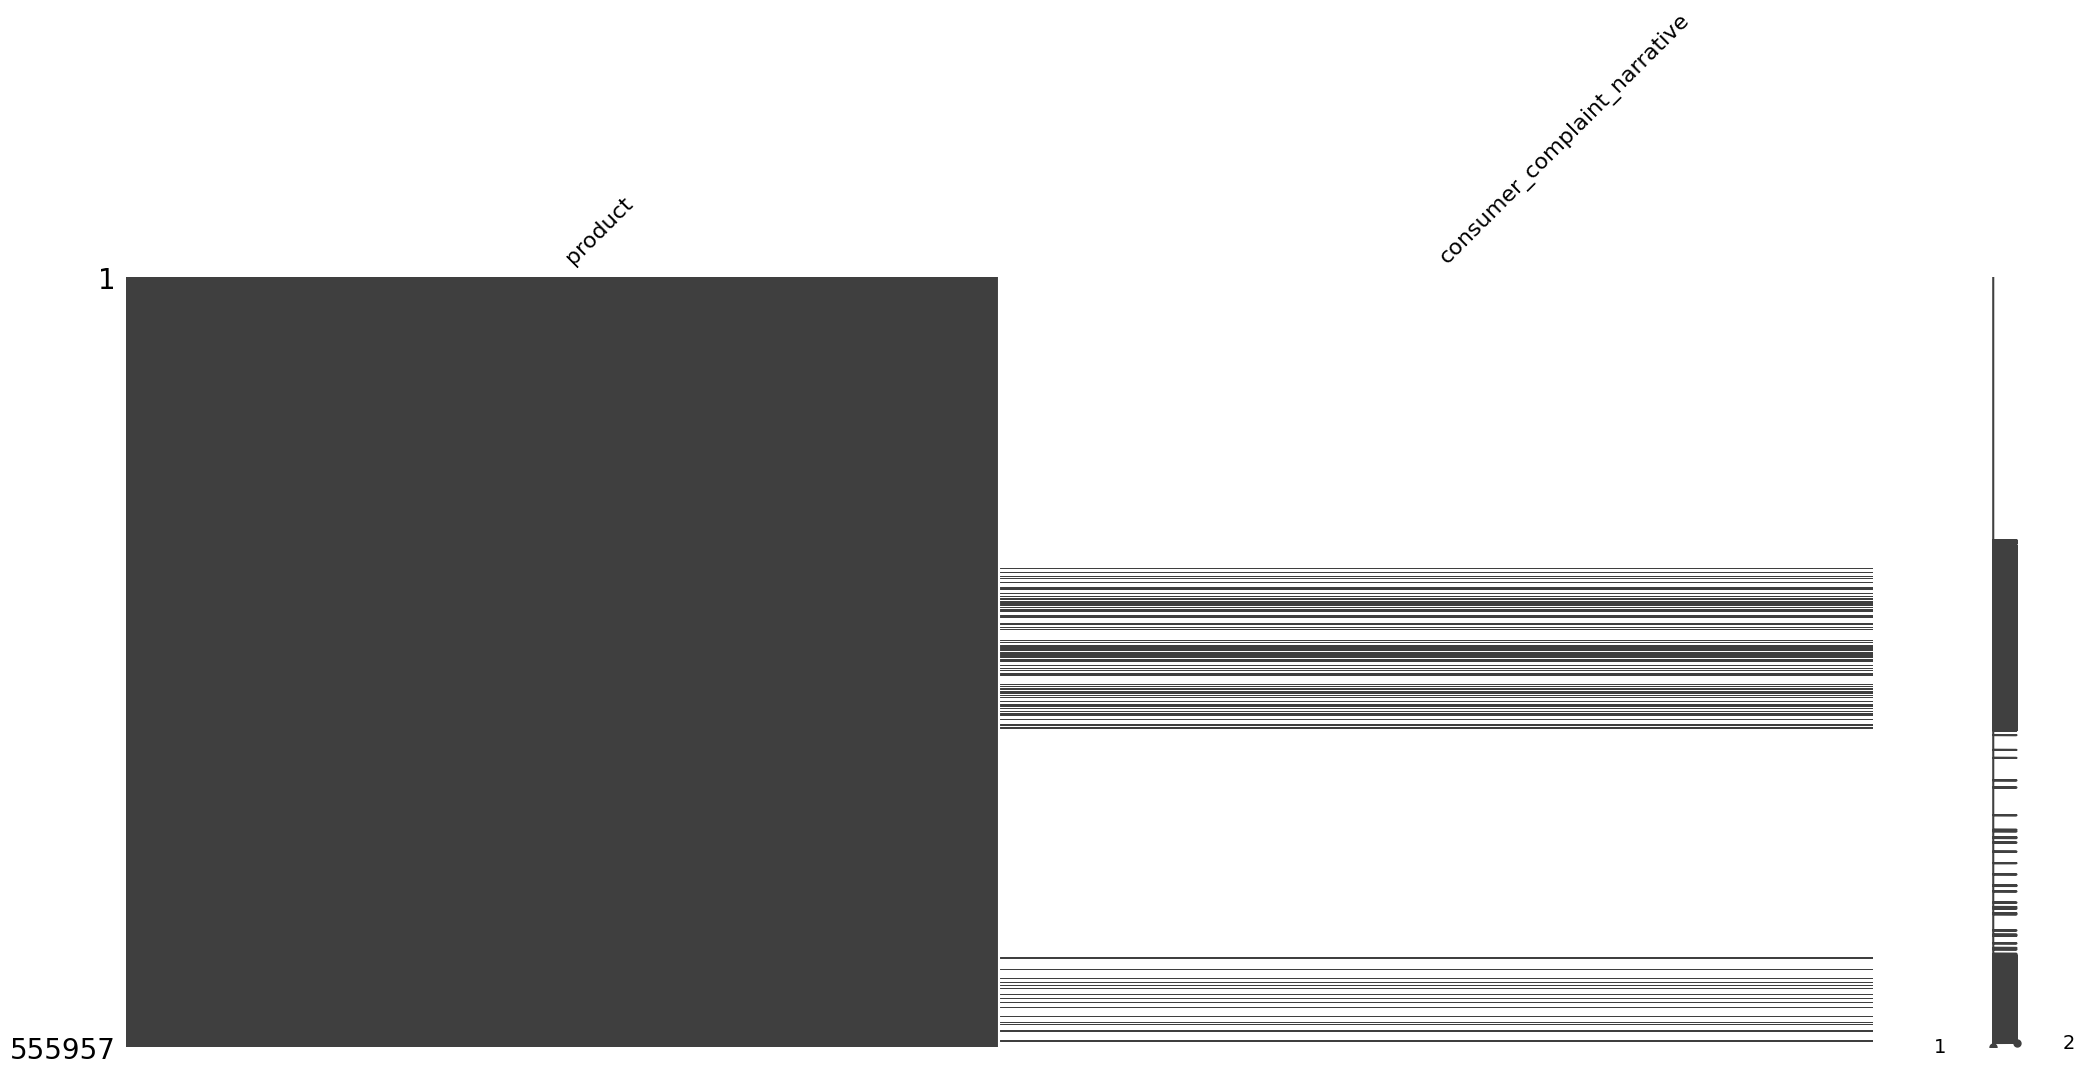

In [2]:
# Set global variables and tokenizer parameters
SUBSAMPLE = False
SEED = 42
LR = 2e-5
BATCH_SIZE = 10
EPOCHS = 5
MAX_LEN = 256

# Define parameters for the tokenizer 
tokenizer_params = {
    'add_special_tokens': True,     # adds [CLS] and [SEP] tags
    'return_attention_mask': True,  # useful for distinguishing between actual data and padding
    'pad_to_max_length': True,      # to ensure all sequences have the same length
    'truncation': True,
    'max_length': MAX_LEN,          # set the maximum length for sequences
}

# Load data 
print("Loading raw data...")
data = pd.read_csv('consumer_complaints.csv')
data = data[['product', 'consumer_complaint_narrative']].reset_index(drop=True)

# Plot missing values 
ms.matrix(data)

# Drop rows with null values
data = data.dropna()

# Sub-sample to speed up the training process 
if SUBSAMPLE: 
    data = data.sample(frac=0.1, random_state=SEED)

# Remove the categories with not enough samples to speed up training
categories_to_drop = ['Consumer Loan',
                    'Bank account or service',
                    'Student loan', 
                    'Prepaid card',
                    'Payday loan', 
                    'Money transfers', 
                    'Other financial service']
data = data[~data['product'].isin(categories_to_drop)]

We can see in the plot that most of the rows don't even contain a narrative about the complaint, so we will remove those as they can't be used to train the model. 

### EDA

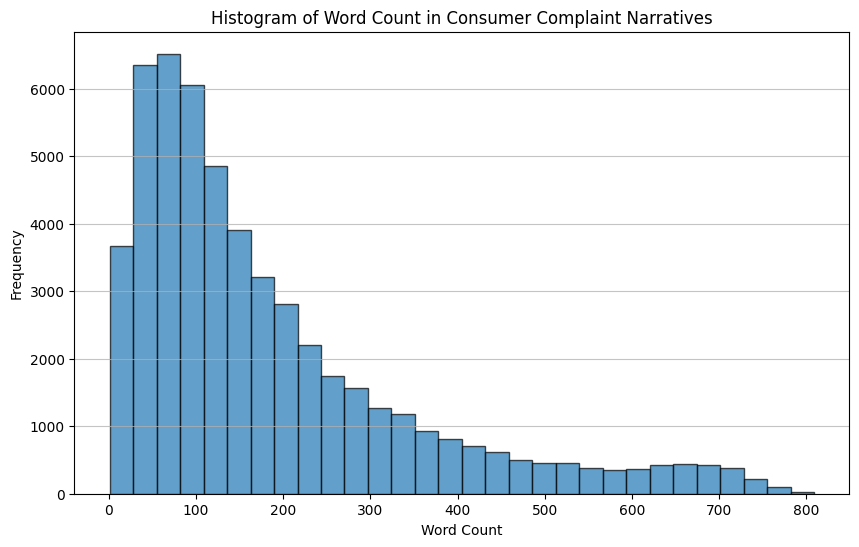

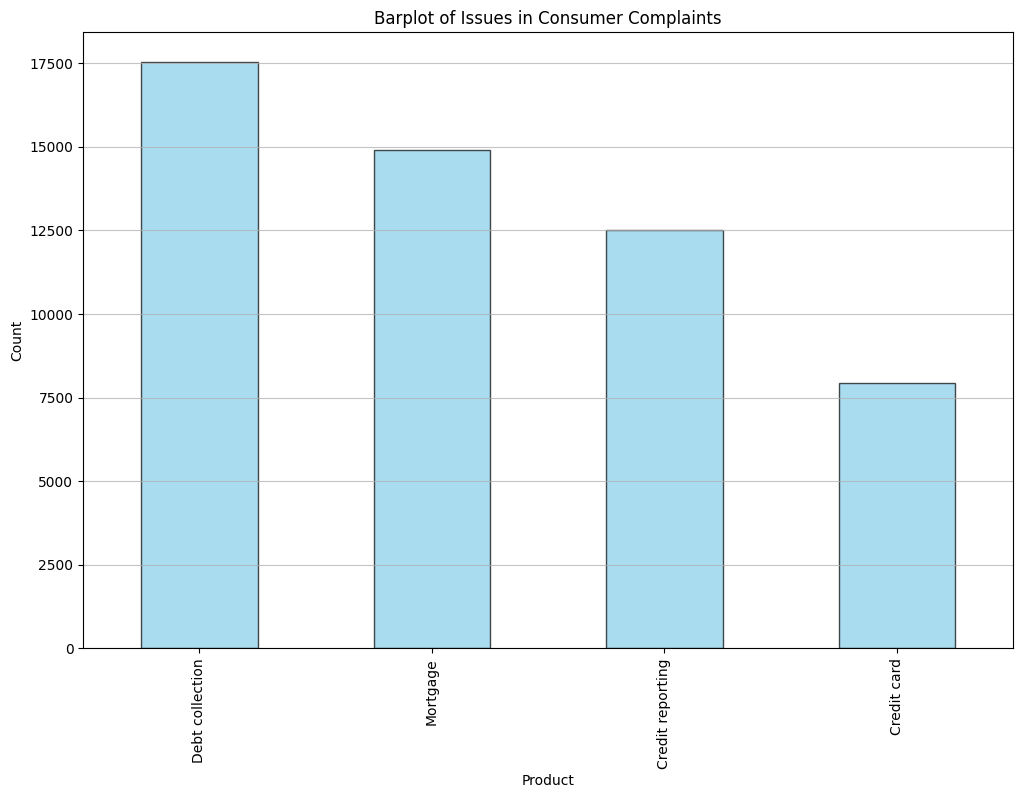

In [3]:
# Category visualization
# Create a histogram with the word count for the column 'consumer_complaint_narrative'
data['narrative_word_count'] = data['consumer_complaint_narrative'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
plt.hist(data['narrative_word_count'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of Word Count in Consumer Complaint Narratives')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Create a barplot counting each unique value in the column 'issue'
issue_counts = data['product'].value_counts()
plt.figure(figsize=(12, 8))
issue_counts.plot(kind='bar', color='skyblue', edgecolor='k', alpha=0.7)
plt.title('Barplot of Issues in Consumer Complaints')
plt.xlabel('Product')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.75)
plt.show()

There are some imbalancement between categories, but this shouldn't be a problem as long as we stratified the data when doing the train-test split and use performance metrics that are robust to imbalanced datasets such as the F1 score. 

### Preprocessing

We need to clean up the strings and encode string categories. 

In [4]:
# Text cleanup
def clean_text(text): 
    text = text.replace('\n', '').strip()
    # text = text.replace('XXXX', '')
    # text = re.sub(r'[^A-Za-z\s]', '', text)   # remove special characters
    return text
data['consumer_complaint_narrative'] = data['consumer_complaint_narrative'].apply(clean_text)

# Encoding labels 
labs_ = data['product'].unique()    # Creates array: ['Debt collection', 'Mortgage', 'Credit card', 'Credit reporting']
lab_dict = dict()    
id_dict = dict()                 
for idx, lab in enumerate(labs_): 
    lab_dict[lab] = idx             # This'll create {'Debt collection': 0, 'Mortgage': 1, 'Credit card': 2,...}
    id_dict[idx] = lab
data['label'] = data['product'].replace(lab_dict)
data.head()

,product,consumer_complaint_narrative,narrative_word_count,label
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...,55,0
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...,666,1
190207,Mortgage,I have an open and current mortgage with Chase...,75,1
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...,259,1
190237,Mortgage,Experian is reporting my OPEN and CURRENT Mort...,72,1


Next up, we need to create the train-test split. We will use 90% of the dataset to train the model. 

Then tokenize and extract input IDs and attention masks. Do we need to use them as inputs for the model. 
- Input ID: array containing the IDs for each token 
- Attention mask: so the model can distinguish between padding and actual data (1 for data, 0 for padding)

In [5]:
# Create train-test split 
X_train, X_val, y_train, y_val = train_test_split(
    data['consumer_complaint_narrative'], 
    data['label'], 
    train_size=0.9,
    test_size=0.1, 
    random_state=SEED,
    stratify=data['label']       # use stratification even if it doesn't seem necessary
    )

# Create dataframes
X_train_df = pd.DataFrame(X_train)
X_train_df['labels'] = y_train
X_val_df = pd.DataFrame(X_val)
X_val_df['labels'] = y_val

# Create datasets
train_dts = Dataset.from_pandas(X_train_df)
eval_dts = Dataset.from_pandas(X_val_df)

# Create dataset dict 
dataset_dict = DatasetDict({"train": train_dts, 
                            "validation": eval_dts})

# Tokenize text
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',
                                                do_lower_case=True)
def tokenize(batch): 
    return tokenizer(batch["consumer_complaint_narrative"], **tokenizer_params)
dataset_dict = dataset_dict.map(tokenize, batched=True, batch_size=BATCH_SIZE)

# Remove and re-order columns 
dataset_dict = dataset_dict.remove_columns(["consumer_complaint_narrative", "__index_level_0__"])

# Transform into tensors to be manipulated by PyTorch 
dataset_dict.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
print(dataset_dict)

# Transform into dataloaders for batch training
train_loader = DataLoader(
    dataset_dict["train"], shuffle=True, batch_size=BATCH_SIZE
)
eval_loader = DataLoader(
    dataset_dict["validation"], batch_size=BATCH_SIZE
)




Parameter 'function'=<function tokenize at 0x0000026DD8C4A790> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
  0%|          | 0/4764 [00:00<?, ?ba/s]d:\llm-solutions\sequence_classification\customer-complaint-classification_DistilBERT\env\lib\site-packages\transformers\tokenization_utils_base.py:2212: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specif

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 47633
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 5293
    })
})


### Benchmarks
Now we create two benchmark models to see if our model can outperform them.
The first benchmark is going to be a simple randomized model. This model is going to make predictions randomly.
The second benchmark model is going to be a zero-shot model from the transformers library.
We want to create a model that obtains better performance than these two.

First, let's define the accuracy functions. We will be using precision (as accuracy is not ideal for imbalanced data), F1 score and a confussion matrix. 

In [ ]:
random.seed(SEED)

# define true values and randomized values
y_true = y_val.sample(1000).values
y_pred = [random.randint(0, 3) for _ in range(len(y_true))]

# Calculate precision
print('Precision score: ', precision_score(y_true, y_pred, average='weighted'))
print('F1 score: ', f1_score(y_true, y_pred, average='weighted'))

# Calculate the confusion matrix
cm = multilabel_confusion_matrix(y_true, y_pred)
print(cm)

# Where 1 means perfect prediction, 0 random predictions, -1 inverse predictions
print(matthews_corrcoef(y_true, y_pred))

del cm
del y_pred
del y_true

Precision score:  0.2564053086419753
F1 score:  0.24162683999527154
[[[489 166]
  [268  77]]

 [[542 177]
  [215  66]]

 [[642 210]
  [108  40]]

 [[565 209]
  [171  55]]]
-0.014584110382625288


As expected, the MCC is close to 0 (= random predictions), and the F1 score is ~0.25, so the model is not really reliable. 

In [ ]:
n_sample = 20
classifier = pipeline("zero-shot-classification", model='facebook/bart-large-mnli')

subsample = data.sample(n=n_sample)
texts_ = subsample['consumer_complaint_narrative']
y_true =  subsample['label']

candidate_labels = [n for n in range(0, 3)]

y_pred = []
for text in texts_: 
    res = classifier(text, candidate_labels=candidate_labels)
    y_pred.append(res['labels'][0])

# Calculate precision
print('Precision score: ', precision_score(y_true, y_pred, average='weighted'))
print('F1 score: ', f1_score(y_true, y_pred, average='weighted'))

# Calculate the confusion matrix
cm = multilabel_confusion_matrix(y_true, y_pred)
print(cm)

# Where 1 means perfect prediction, 0 random predictions, -1 inverse predictions
print(matthews_corrcoef(y_true, y_pred))

del cm
del subsample
del y_pred
del y_true

Precision score:  0.15555555555555556
F1 score:  0.21538461538461542
[[[12  1]
  [ 7  0]]

 [[ 1 11]
  [ 1  7]]

 [[17  1]
  [ 2  0]]

 [[17  0]
  [ 3  0]]]
-0.09129609692138818


c:\Users\hp\Desktop\context_detector\env\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The zero-shot model performed slightly better.

### Train Loop - Fine-tuned Version

In this section, we will load a pre-trained model from the `transformers` library and declare the optimizer and scheduler for the training loop. These components are crucial for effectively training the model.

#### Optimizer

The optimizer is an algorithm that adjusts the weights of the neural network to minimize the loss function. It does this by computing the gradients of the loss function with respect to the model parameters and then updating the parameters in the direction that reduces the loss. Common optimizers include SGD (Stochastic Gradient Descent), Adam (Adaptive Moment Estimation), and RMSprop. In this notebook, we use the `AdamW` optimizer, which is a variant of Adam that incorporates weight decay (regularization) to reduce overfitting.

#### Scheduler

The scheduler adjusts the learning rate during training. The learning rate determines the step size at each iteration while moving toward a minimum of the loss function. By modifying the learning rate, the scheduler helps the model escape local minima and converge more efficiently. For example, a common approach is to start with a higher learning rate and gradually decrease it, allowing the model to make significant progress initially and then fine-tune the parameters more carefully.

Both the optimizer and scheduler are essential for ensuring that the training process is efficient and that the model converges to a good solution.


C:\Users\hp\AppData\Local\Temp\ipykernel_20928\3012027948.py:6: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'object'):
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Disti

Starting model training...



Epoch 1/5:   0%|          | 0/4764 [22:49<?, ?it/s]


Epoch: 1/5
Training loss: 0.3049
Validation loss: 0.2248
F1 Score: 0.9220
Precision: 0.9227



Epoch 2/5:   0%|          | 0/4764 [22:39<?, ?it/s]


Epoch: 2/5
Training loss: 0.1730
Validation loss: 0.2042
F1 Score: 0.9332
Precision: 0.9333



Epoch 3/5:   0%|          | 0/4764 [21:36<?, ?it/s]


Epoch: 3/5
Training loss: 0.1074
Validation loss: 0.2303
F1 Score: 0.9264
Precision: 0.9271



Epoch 4/5:   0%|          | 0/4764 [21:26<?, ?it/s]


Epoch: 4/5
Training loss: 0.0592
Validation loss: 0.2608
F1 Score: 0.9285
Precision: 0.9286



Epoch 5/5:   0%|          | 0/4764 [21:27<?, ?it/s]


Epoch: 5/5
Training loss: 0.0327
Validation loss: 0.2995
F1 Score: 0.9292
Precision: 0.9293



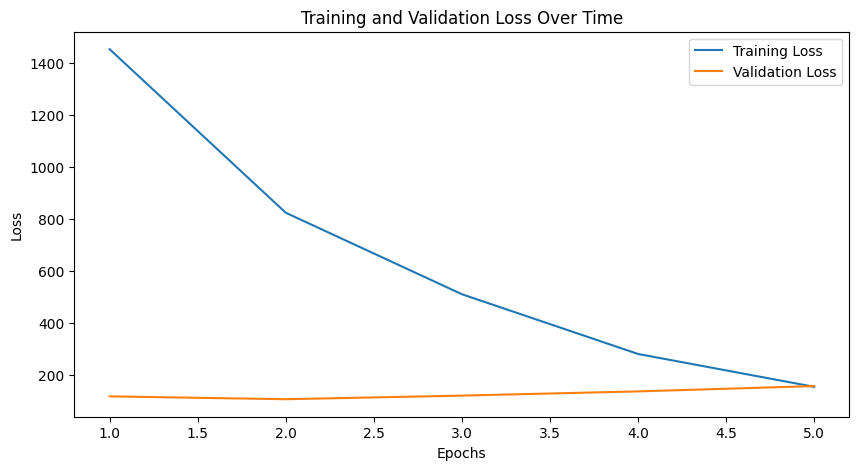

In [7]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

if not hasattr(np, 'object'):
    np.object = object
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load checkpoint 
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", 
                                                            num_labels=len(lab_dict), 
                                                            output_attentions=False)

# Move model to device
model.to(device)

# Load optimizer 
optimizer = AdamW(model.parameters(),
                lr=LR,   
                eps=1e-8)       # add constant to prevent division by zero 

# Define scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=100, 
                                            num_training_steps=len(train_loader) * EPOCHS)

# Accuracy metrics
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")

# Initialize lists to store losses for plotting
training_losses = []
validation_losses = []

# Training loop 
print("Starting model training...\n")
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    
    with tqdm(train_loader, desc=f'Epoch {epoch + 1}/{EPOCHS}'):
        for batch in train_loader:
            batch = {k: b.to(device) for k, b in batch.items()}             # move the batch to the device 
            outputs = model(**batch)  

            # Compute loss
            loss = outputs.loss
            loss.backward()
            train_loss += loss.item()
            
            optimizer.step()                                                # update parameters
            scheduler.step()                                                # update learning rate 
            optimizer.zero_grad()                                           # clear previous gradients
            # progress_bar.update(1)
        
    avg_train_loss = train_loss / len(train_loader)
    torch.save(model.state_dict(), f'models/BERT_epoch_{epoch+1}.model')

    # Evaluation loop 
    model.eval()
    val_loss = 0 
    for batch in eval_loader: 
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            loss = outputs.loss
            val_loss += loss.item()

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        # Evaluate predictions
        f1_metric.add_batch(predictions=predictions, references=batch['labels'])
        precision_metric.add_batch(predictions=predictions, references=batch['labels'])
        
    avg_val_loss = val_loss / len(eval_loader)
    f1 = f1_metric.compute(average='weighted')
    precision = precision_metric.compute(average='weighted')

    training_losses.append(train_loss)
    validation_losses.append(val_loss)


    print(f"Epoch: {epoch + 1}/{EPOCHS}")
    print(f"Training loss: {avg_train_loss:.4f}")
    print(f"Validation loss: {avg_val_loss:.4f}")
    print(f"F1 Score: {f1['f1']:.4f}")
    print(f"Precision: {precision['precision']:.4f}")
    print("================================\n")

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), training_losses, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

During the training process, the model undergoes several epochs where it learns from the training data and is evaluated on the validation data. Here is a summary of the output:

**Training and Validation Metrics**:
   - **Training Loss**: Indicates how well the model is fitting the training data. A decreasing training loss suggests that the model is learning.
   - **Validation Loss**: Indicates how well the model is performing on unseen data. It helps in understanding if the model is overfitting or generalizing well.
   - **F1 Score**: A measure of the model's accuracy that considers both precision and recall. It is useful for evaluating the balance between the model's precision and recall.
   - **Precision**: Measures the accuracy of the positive predictions.

#### Conclusion:

The model shows a consistent decrease in training loss, indicating effective learning. The validation loss fluctuates but remains within a reasonable range, suggesting that the model is not severely overfitting. The high F1 Score and precision across epochs indicate that the model performs well in distinguishing between the classes.

By analyzing these metrics, we decide to adjust our training parameters and include a tailored model with some regularization techniques to prevent overfitting. 

# Custom Model Training Loop

In this section, we aim to enhance our model's performance by implementing a custom model architecture based on `DistilBERT`. The custom model allows us to have more control over the architecture and the training process, potentially improving the model's ability to generalize to new data.

#### Goals

1. **Custom Architecture**:
    - Define a custom neural network architecture using `DistilBERT` as the base model.
    - Add a dropout layer to prevent overfitting and a fully connected layer to output the final predictions.

2. **Optimizer and Scheduler**:
    - Use the `AdamW` optimizer, which combines the Adam algorithm with weight decay for regularization.
    - Implement a learning rate scheduler to adjust the learning rate dynamically during training. This helps in escaping local minima and improves convergence.

3. **Training Loop**:
    - Train the model over several epochs, monitoring both training and validation losses.
    - Calculate and track performance metrics such as F1 Score and Precision to evaluate the model's effectiveness.

4. **Loss Function**:
    - Use `CrossEntropyLoss` for multi-class classification, which measures the performance of the classification model whose output is a probability value between 0 and 1.

By integrating these components, we aim to create a robust training loop that improves the model's ability to learn from the data and generalize well to new, unseen examples.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Starting model training...



Epoch 1/5:   0%|          | 0/4764 [21:21<?, ?it/s]


Epoch: 1/5
Training loss: 0.2959
Validation loss: 0.2191
F1 Score: 0.9246
Precision: 0.9249



Epoch 2/5:   0%|          | 0/4764 [21:20<?, ?it/s]


Epoch: 2/5
Training loss: 0.1752
Validation loss: 0.2016
F1 Score: 0.9336
Precision: 0.9336



Epoch 3/5:   0%|          | 0/4764 [21:24<?, ?it/s]


Epoch: 3/5
Training loss: 0.1079
Validation loss: 0.2244
F1 Score: 0.9306
Precision: 0.9306



Epoch 4/5:   0%|          | 0/4764 [22:28<?, ?it/s]


Epoch: 4/5
Training loss: 0.0585
Validation loss: 0.2662
F1 Score: 0.9288
Precision: 0.9290



Epoch 5/5:   0%|          | 0/4764 [21:23<?, ?it/s]


Epoch: 5/5
Training loss: 0.0332
Validation loss: 0.2874
F1 Score: 0.9297
Precision: 0.9298



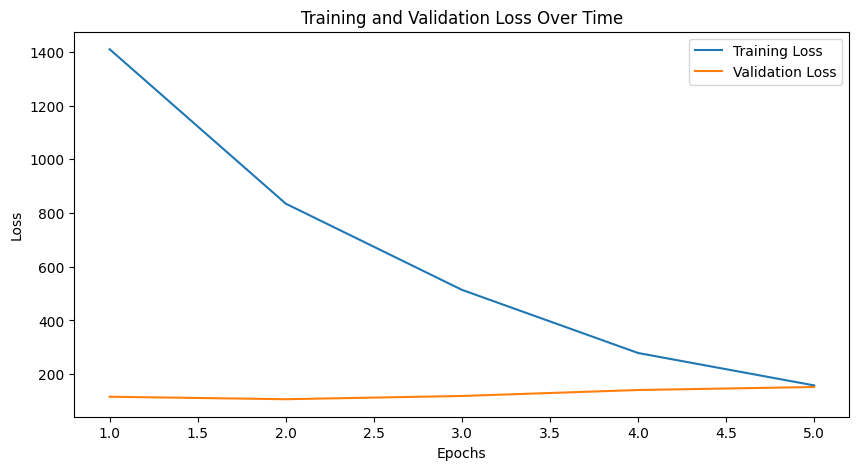

In [8]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define custom model 
class TextClassifier(torch.nn.Module): 
    def __init__(self): 
        super(TextClassifier, self).__init__()
        self.distilbert = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased', num_labels=len(lab_dict))
        self.dropout = torch.nn.Dropout(0.3)
        self.output = torch.nn.Linear(768, len(lab_dict))

    # Define forward function 
    def forward(self, input_ids, attention_mask, labels=None):
        output = self.distilbert(input_ids, attention_mask=attention_mask)
        output = self.dropout(output[0][:, 0, :])  # Use the [CLS] token representation
        logits = self.output(output)
        return logits

# Accuracy metrics
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")

# Declare model and move to device
model = TextClassifier()
model.to(device)

# Load optimizer 
optimizer = AdamW(model.parameters(),
                lr=LR,   
                eps=1e-8)       # add constant to prevent division by zero 

# Define scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=10, 
                                            num_training_steps=len(train_loader) * EPOCHS)

# Loss function. CrossEntropyLoss for multi-class classification
loss_function = nn.CrossEntropyLoss()  

# Initialize lists to store losses for plotting
training_losses = []
validation_losses = []

# Define training loop 
print("Starting model training...\n")
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0 

    with tqdm(train_loader, desc=f'Epoch {epoch + 1}/{EPOCHS}'):
        for batch in train_loader:
            batch = {k: b.to(device) for k, b in batch.items()}             # move the batch to the device 
            outputs = model(**batch)  

            # Compute loss
            loss = loss_function(outputs, batch['labels'])
            loss.backward()
            train_loss += loss.item()

            optimizer.step()                                                # update parameters
            scheduler.step()                                                # update learning rate 
            optimizer.zero_grad()                                           # clear previous gradients
    
    avg_train_loss = train_loss / len(train_loader)
    torch.save(model.state_dict(), f'models/finetuned_BERT_epoch_{epoch+1}.model')

    # Evaluation loop 
    model.eval()
    val_loss = 0 
    for batch in eval_loader: 
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            loss = loss_function(outputs, batch['labels'])
            val_loss += loss.item()
        logits = outputs
        predictions = torch.argmax(logits, dim=-1)

        # Evaluate predictions
        f1_metric.add_batch(predictions=predictions, references=batch['labels'])
        precision_metric.add_batch(predictions=predictions, references=batch['labels'])

    avg_val_loss = val_loss / len(eval_loader)
    f1 = f1_metric.compute(average='weighted')
    precision = precision_metric.compute(average='weighted')

    training_losses.append(train_loss)
    validation_losses.append(val_loss)

    print(f"Epoch: {epoch + 1}/{EPOCHS}")
    print(f"Training loss: {avg_train_loss:.4f}")
    print(f"Validation loss: {avg_val_loss:.4f}")
    print(f"F1 Score: {f1['f1']:.4f}")
    print(f"Precision: {precision['precision']:.4f}")
    print("================================\n")

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), training_losses, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

#### Analysis and Comparison:

**Training Loss:**
- Both models show a decreasing trend in training loss, indicating effective learning.
- The training loss values of the custom model are slightly lower in the initial epochs compared to the previous model, but converge similarly towards the end.

**Validation Loss:**
- The validation loss for both models fluctuates across epochs.
- The custom model has a lower validation loss in the initial epochs (1 and 2), suggesting it generalizes better early on.
- In later epochs, the validation loss of the custom model increases, similar to the previous model, suggesting potential overfitting.

**F1 Score:**
- Both models achieve high F1 Scores, indicating balanced precision and recall.
- The custom model slightly outperforms the previous model in most epochs, especially in the initial and final epochs.

**Precision:**
- Precision values are very close for both models, consistently high across epochs.
- The custom model shows a marginal improvement in precision over the previous model.

#### Conclusion:

* Performance: The custom model shows marginal improvements in F1 Score and precision, especially in the initial epochs. The lower initial validation loss suggests better generalization early on.
* Overfitting: Both models show signs of overfitting as indicated by increasing validation loss in later epochs.
* Recommendation: Further fine-tuning, regularization techniques, or early stopping could help in reducing overfitting and improving overall performance.

Both models are performing well, but the custom model has a slight edge in terms of metrics, making it a potentially better choice for deployment or further fine-tuning.